# Kaggle Project-3
# Chest X-Ray Images (Pneumonia) Classification
- 출처(source) : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

- 목표 : ImageDataGenerator와 TL(transfer learning)을 이용해서 과대적합을 최소화하여 90%이상의 정확도 달성
goal : Minimize overfitting and achieve 90% or more accuracy


# Datasets

In [1]:
# Google mount
# 구글 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 현재 디렉토리 /content로 이미지 데이터 복사 후 현재 디렉토리 ROOT_DIR로 명명
# Copy image data to /content and name /content ROOT_DIR
import shutil
import os

shutil.copy(os.path.join("/content/drive/MyDrive/Colab Notebooks/", "chest_xray.zip"), "/content")
ROOT_DIR = "/content"

In [3]:
# chest_xray 디렉토리 생성과 동시에 압축해제 후 chest_xray 디렉토리 DATA_ROOT_DIR로 명명
# Decompress data in chest_xray zip and name chest_xray dir DATA_ROOT_DIR
import zipfile
with zipfile.ZipFile("/content/chest_xray.zip", "r") as target_file:
  target_file.extractall("/content/chest_xray")
  DATA_ROOT_DIR = "/content/chest_xray"


# Path Naming

In [4]:
# chest_xray dir 내 test, train 그리고 val dir를 각각 TEST_DATA_ROOT_DIR, TRIAN_DATA_ROOT_DIR 그리고 VAL_DATA_DIR로 명명
# Name test dir, train dir and val dir in chest_xray dir TEST_DATA_ROOT_DIR, TRAIN_DATA_ROOT_DIR, VAL_DATA_DIR
TRAIN_DATA_ROOT_DIR = "/content/chest_xray/train"
TEST_DATA_ROOT_DIR = "/content/chest_xray/test"
VAL_DATA_ROOT_DIR = "/content/chest_xray/val"

# Checking total number of data and labels

In [5]:
# 훈련 데이터 개수 파악
# number of Training data

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(label_name_list)

for label_name in label_name_list:
  print(label_name, "=>", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['PNEUMONIA', 'NORMAL']
PNEUMONIA => 3875
NORMAL => 1341


In [6]:
# 테스트 데이터 개수 파악
# number of Testing data

print(label_name_list)

for label_name in label_name_list:
  print(label_name, "=>", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

['PNEUMONIA', 'NORMAL']
PNEUMONIA => 390
NORMAL => 234


In [7]:
# 검증 데이터 개수 파악
# number of validation data

print(label_name_list)

for label_name in label_name_list:
  print(label_name, "=>", len(os.listdir(os.path.join(VAL_DATA_ROOT_DIR, label_name))))

['PNEUMONIA', 'NORMAL']
PNEUMONIA => 8
NORMAL => 8


# Setting image shape

In [8]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR,
                                                   batch_size=32,
                                                   color_mode="rgb",
                                                   class_mode="sparse",
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT))

test_generator = train_datagen.flow_from_directory(TEST_DATA_ROOT_DIR,
                                                   batch_size=32,
                                                   color_mode="rgb",
                                                   class_mode="sparse",
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT))

val_generator = val_datagen.flow_from_directory(VAL_DATA_ROOT_DIR,
                                                   batch_size=32,
                                                   color_mode="rgb",
                                                   class_mode="sparse",
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
# 레이블과 레이블 개수 확인
# checking labels and the number of labels

print(train_generator.class_indices, train_generator.num_classes)
print(test_generator.class_indices, test_generator.num_classes)
print(val_generator.class_indices, val_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1} 2
{'NORMAL': 0, 'PNEUMONIA': 1} 2
{'NORMAL': 0, 'PNEUMONIA': 1} 2


# 32개의 이미지 확인
- ImageDataGenerator로 전달 된 이미지 확인

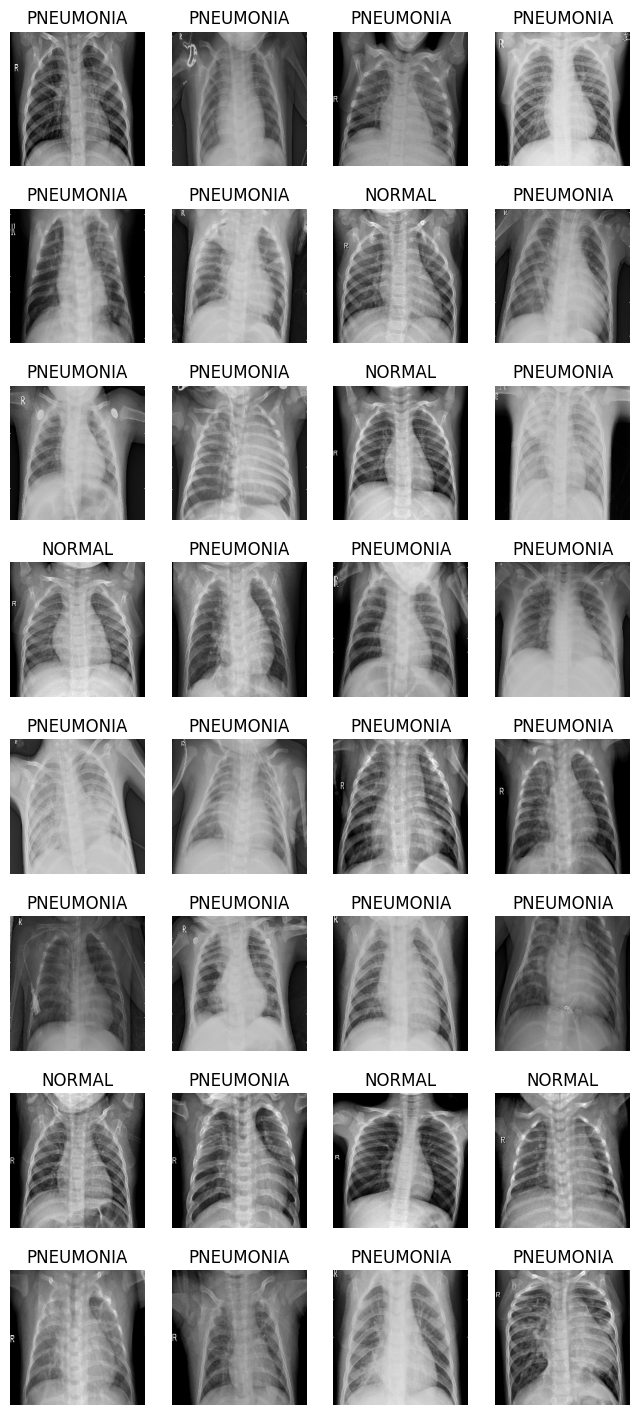

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 18))

images_32 = train_generator.next()
for i in range(len(images_32[1])):
  plt.subplot(8, 4, i+1)
  plt.imshow(images_32[0][i])
  plt.title(list(train_generator.class_indices.keys())[int(images_32[1][i])])
  plt.axis("off")

# Transfer Learning

In [12]:
# fine tunning을 위한 학습된 모델 구축(MobileNet)
# Establishing pre-trained model(MobileNet) for fine tunning
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNet, Xception

pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
pre_trained_model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

# Fine Tunning

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

model = Sequential()

model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [15]:
# 콜백 함수
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint("Chest_X-Ray_Images_Pneumonia_h5_model.h5", monitor='val_loss', save_best_only=True)

In [16]:
# 컴파일
from tensorflow.keras.optimizers import Adam

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

# Train

In [17]:
from datetime import datetime

start_time = datetime.now()

result = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[mc])

end_time = datetime.now()
print("ELapsed Time :", end_time - start_time)

Epoch 1/30
163/163 [==============================] - 85s 368ms/step - loss: 0.5837 - accuracy: 0.7268 - val_loss: 1.4631 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 58s 357ms/step - loss: 0.2358 - accuracy: 0.9011 - val_loss: 1.7723 - val_accuracy: 0.5625
Epoch 3/30
163/163 [==============================] - 58s 356ms/step - loss: 0.1517 - accuracy: 0.9448 - val_loss: 1.5880 - val_accuracy: 0.6250
Epoch 4/30
163/163 [==============================] - 61s 372ms/step - loss: 0.1184 - accuracy: 0.9567 - val_loss: 0.9844 - val_accuracy: 0.7500
Epoch 5/30
163/163 [==============================] - 61s 375ms/step - loss: 0.0969 - accuracy: 0.9624 - val_loss: 0.7681 - val_accuracy: 0.7500
Epoch 6/30
163/163 [==============================] - 59s 364ms/step - loss: 0.0826 - accuracy: 0.9711 - val_loss: 0.5433 - val_accuracy: 0.8125
Epoch 7/30
163/163 [==============================] - 60s 365ms/step - loss: 0.0658 - accuracy: 0.9758 - val_loss: 0.4833 - val_ac

# Visualizaiton

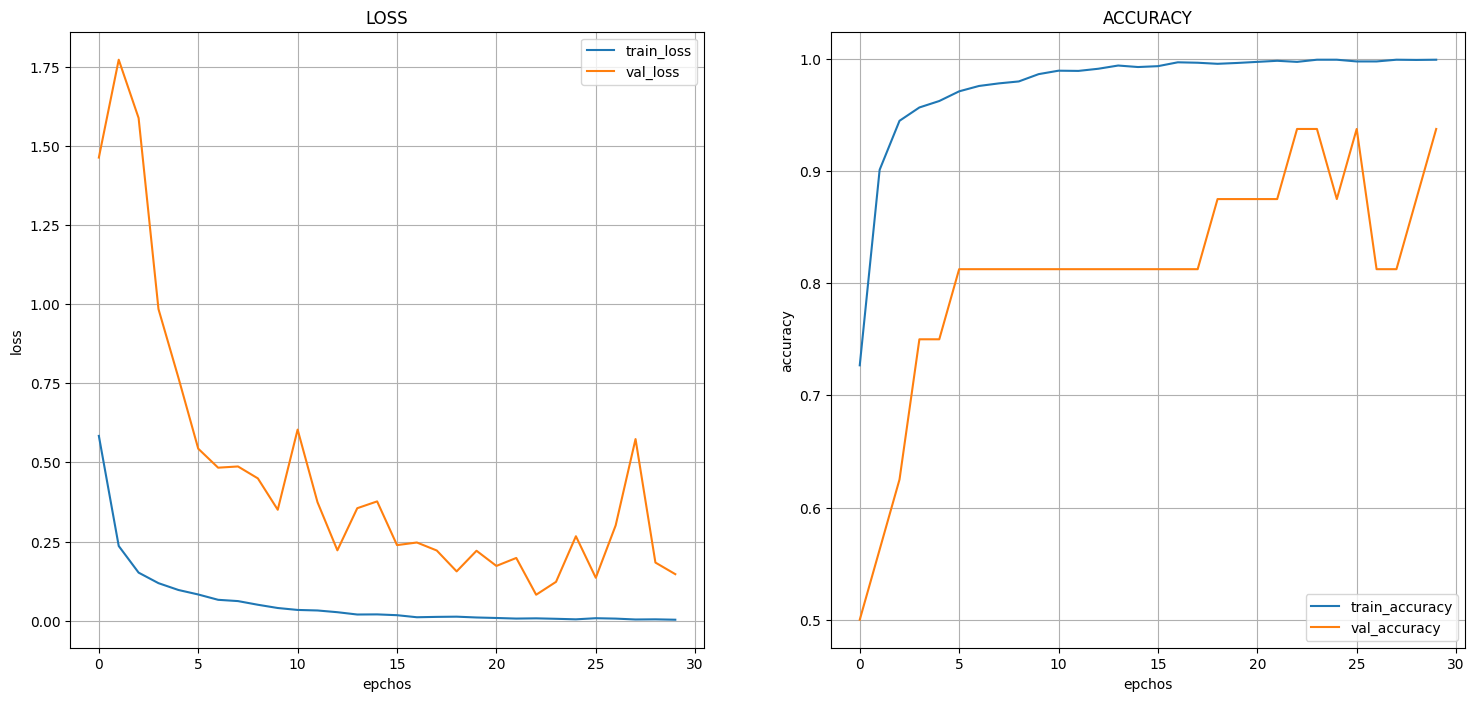

In [18]:
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.title("LOSS")
plt.xlabel("epchos")
plt.ylabel("loss")
plt.grid()
plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="val_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("ACCURACY")
plt.xlabel("epchos")
plt.ylabel("accuracy")
plt.grid()
plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="val_accuracy")
plt.legend(loc="best")